In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv("Gemini_1INCHUSD_1h.csv")
df.index = pd.to_datetime(df.index)
df.set_index('date', inplace = True)
df.head(n=5)

,unix,symbol,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,,,
2022-04-27 00:00:00,1651017600000,1INCH/USD,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1651014000000,1INCH/USD,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1651010400000,1INCH/USD,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1651006800000,1INCH/USD,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1651003200000,1INCH/USD,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620


In [4]:
timesteps = df.index.to_numpy()
volume_usd = df['Volume 1INCH'].to_numpy()

split_size = int(0.8 * len(volume_usd))

X_train, y_train = timesteps[:split_size], volume_usd[:split_size]
X_test, y_test = timesteps[split_size:], volume_usd[split_size:]

def split_train_test(timesteps, prices, train_size):
    split_size = int(0.8 * len(prices))

    X_train, y_train = timesteps[:split_size], prices[:split_size]
    X_test, y_test = timesteps[split_size:], prices[split_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_train_test(timesteps, volume_usd, 0.8)
print(len(X_train), len(y_train), len(X_test), len(y_test))

1572 1572 393 393


In [25]:
def get_labelled_windows(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size = 7, horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon = 1)
    return windows, labels

full_windows, full_labels = make_windows(volume_usd, window_size = 7, horizon = 1)

for i in range(3):
    print("Window: {}".format(full_windows[i]), "Labels: {}".format(full_labels[i]))

train_labels, train_windows, test_labels, test_windows = split_train_test(full_labels, full_windows, 0.8)
print("Train Windows: {} and Train Labels: {}".format(len(train_windows), len(train_labels)))
print("Test Windows: {} and Test Labels: {}".format(len(test_windows), len(test_labels)))

Window: [  428.840257  1189.529669  1281.291941  2868.856831  2084.128819
 12134.329536   460.162917] Labels: [2447.070851]
Window: [ 1189.529669  1281.291941  2868.856831  2084.128819 12134.329536
   460.162917  2447.070851] Labels: [1160.667932]
Window: [ 1281.291941  2868.856831  2084.128819 12134.329536   460.162917
  2447.070851  1160.667932] Labels: [53402.885216]
Train Windows: 1566 and Train Labels: 1566
Test Windows: 392 and Test Labels: 392


In [27]:
def get_callbacks(model_name, path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_name, path), 
    save_best_only = True, verbose = 0)

WINDOW_SIZE, HORIZON = 7, 1

inputs = tf.keras.layers.Input(shape = (WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
x = tf.keras.layers.LSTM(128, activation = 'relu', return_sequences = True)(x)
x = tf.keras.layers.LSTM(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
outputs= tf.keras.layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_lstm")

model_lstm.compile(loss = tf.keras.losses.MeanAbsoluteError(),
optimizer = tf.keras.optimizers.Adam())

model_lstm.fit(train_windows, train_labels, epochs = 50, verbose = 0, batch_size = 128,
validation_data = (test_windows, test_labels), callbacks = [get_callbacks(model_name = model_lstm.name)])

INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets
INFO:tensorflow:Assets written to: model_lstm\model_experiments\assets


In [28]:
model_lstm_1 = tf.keras.models.load_model('model_experiments/model_lstm')
model_lstm_1.evaluate(test_windows, test_labels)

13/13 [==============================] - 0s 997us/step - loss: 1084.7080


1084.7080078125

In [30]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

model_lstm_preds = make_preds(model_lstm, test_windows)
model_lstm_preds[:10]

model_lstm_preds = np.array(model_lstm_preds)

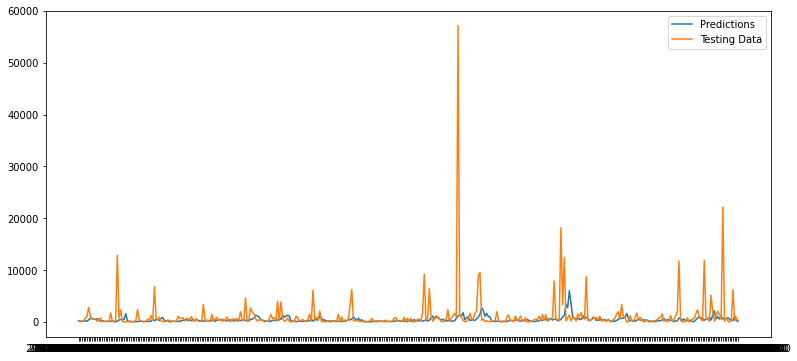

In [33]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(X_test[1:], model_lstm_preds, label = "Predictions")
ax.plot(X_test[2:], y_test[2:], label = "Testing Data")
ax.legend()